# Cell 1a — Setup & Data Loading

Setup: Import NumPy/Pandas; set file paths, target (income), and seed = 22.

Preprocessor: Clean strings, detect numeric vs. categorical; numerics → median-fill + standardize; categoricals → mode-fill + one-hot using levels learned in fit.

Load & target: Read CSV; make y (>50K → 1, else 0) and drop target from features.

Transform: Fit preprocessor on features and convert to an all-numeric design matrix.

Split & check: Do a class-balanced 80/20 train/test split (reproducible) and print the resulting shapes.

In [1]:
# ===== Cell 1a =====
import numpy as np
import pandas as pd

# --- fixed paths (as requested) ---
PATH_TRAIN = r"C:\Users\conre\OneDrive\Desktop\Coding Folder\.csv files\project_adult.csv"
PATH_VALIN = r"C:\Users\conre\OneDrive\Desktop\Coding Folder\.csv files\project_validation_inputs.csv"

TARGET_COL = "income"
RANDOM_STATE = 22

# ----- simple preprocessor -----
class SimplePreprocessor:
    def __init__(self):
        self.num_cols = []
        self.cat_cols = []
        self.num_median = None
        self.num_mean = None
        self.num_std = None
        self.cat_modes = {}
        self.cat_levels = {}

    def _clean(self, df):
        X = df.copy()
        if "Unnamed: 0" in X.columns: X = X.drop(columns=["Unnamed: 0"])
        if "index" in X.columns: X = X.drop(columns=["index"])
        for c in X.columns:
            if X[c].dtype == object:
                X[c] = (X[c].astype(str).str.strip()
                        .replace({"?": np.nan, " ?": np.nan}))
        return X

    def fit(self, df):
        X = self._clean(df)
        self.num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
        self.cat_cols = [c for c in X.columns if c not in self.num_cols]

        nums = X[self.num_cols] if self.num_cols else pd.DataFrame(index=X.index)
        self.num_median = nums.median() if self.num_cols else pd.Series(dtype=float)
        self.num_mean   = nums.fillna(self.num_median).mean() if self.num_cols else pd.Series(dtype=float)
        std = nums.fillna(self.num_median).std(ddof=0) if self.num_cols else pd.Series(dtype=float)
        self.num_std = std.replace(0, 1.0)

        for c in self.cat_cols:
            col = X[c]
            mode = col.mode(dropna=True)
            self.cat_modes[c] = mode.iloc[0] if not mode.empty else None
            self.cat_levels[c] = list(pd.Series(col.dropna().unique()).astype(str))
        return self

    def transform(self, df):
        X = self._clean(df)

        # numeric block
        if self.num_cols:
            num = X[self.num_cols].apply(pd.to_numeric, errors="coerce").fillna(self.num_median)
            num = (num - self.num_mean) / self.num_std
            num_arr = num.to_numpy(dtype=float)
        else:
            num_arr = np.empty((len(X), 0))

        # categorical block (fixed levels learned in fit)
        cats_list = []
        for c in self.cat_cols:
            col = X[c].astype(str).where(~X[c].isna(), self.cat_modes[c]).fillna(self.cat_modes[c]).astype(str)
            levels = self.cat_levels[c]
            mat = np.zeros((len(X), len(levels)), dtype=float)
            idx = {lvl: j for j, lvl in enumerate(levels)}
            for i, v in enumerate(col):
                j = idx.get(v)
                if j is not None:
                    mat[i, j] = 1.0
            cats_list.append(mat)
        cat_arr = np.concatenate(cats_list, axis=1) if cats_list else np.empty((len(X), 0))

        return np.concatenate([num_arr, cat_arr], axis=1)

    def save(self, path):
        with open(path, "wb") as f:
            pickle.dump(self, f)

    @staticmethod
    def load(path):
        with open(path, "rb") as f:
            return pickle.load(f)

# ---- load ----
raw = pd.read_csv(PATH_TRAIN)
if TARGET_COL not in raw.columns:
    raise ValueError(f"Missing target column '{TARGET_COL}'.")

y_str = raw[TARGET_COL].astype(str).str.strip()
y = (y_str == ">50K").astype(int).to_numpy()  # 1 for >50K, 0 otherwise
Xdf = raw.drop(columns=[TARGET_COL])

preproc = SimplePreprocessor().fit(Xdf)
X_all = preproc.transform(Xdf)

# ---- stratified 80/20 split ----
rng = np.random.default_rng(RANDOM_STATE)
idx = np.arange(len(X_all))
pos = idx[y == 1]; rng.shuffle(pos)
neg = idx[y == 0]; rng.shuffle(neg)
cut_p = int(0.8 * len(pos)); cut_n = int(0.8 * len(neg))
train_idx = np.concatenate([pos[:cut_p], neg[:cut_n]])
test_idx  = np.concatenate([pos[cut_p:], neg[cut_n:]])
rng.shuffle(train_idx); rng.shuffle(test_idx)

X_train, X_test = X_all[train_idx], X_all[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print(f"X_train {X_train.shape}, X_test {X_test.shape}")


X_train (20838, 105), X_test (5210, 105)


# Cell 1b — Model Training

Model setup: Builds a simple 1-hidden-layer MLP (d_in → 64 → 2) with ReLU hidden activations and softmax outputs; weights initialized from a small normal, biases = 0 (seeded for reproducibility).

Targets: Converts y_train (0/1) into 2-class one-hot vectors for training.

Forward/Backward:

- Forward: X → Z1 → ReLU → Z2 → softmax → P.

- Loss: Mean Squared Error (MSE) between one-hot labels and softmax probs.

- Backward: Computes gradients for all params and prepares them for an SGD step.

Training loop: Runs for EPOCHS=300 with mini-batches (BATCH=256), shuffles each epoch, does SGD updates with LR=0.01, and logs epoch MSE.

Visualization: Plots the training loss curve (MSE vs. epoch) to check convergence.

Running though Epochs:
Epoch 1/300 - MSE: 0.196452
Epoch 10/300 - MSE: 0.108699
Epoch 20/300 - MSE: 0.102531
Epoch 30/300 - MSE: 0.100119
Epoch 40/300 - MSE: 0.099026
Epoch 50/300 - MSE: 0.098405
Epoch 60/300 - MSE: 0.097974
Epoch 70/300 - MSE: 0.097642
Epoch 80/300 - MSE: 0.097365
Epoch 90/300 - MSE: 0.097149
Epoch 100/300 - MSE: 0.096940
Epoch 110/300 - MSE: 0.096766
Epoch 120/300 - MSE: 0.096578
Epoch 130/300 - MSE: 0.096398
Epoch 140/300 - MSE: 0.096238
Epoch 150/300 - MSE: 0.096044
Epoch 160/300 - MSE: 0.095880
Epoch 170/300 - MSE: 0.095708
Epoch 180/300 - MSE: 0.095590
Epoch 190/300 - MSE: 0.095414
Epoch 200/300 - MSE: 0.095276
Epoch 210/300 - MSE: 0.095100
Epoch 220/300 - MSE: 0.094959
Epoch 230/300 - MSE: 0.094865
Epoch 240/300 - MSE: 0.094690
Epoch 250/300 - MSE: 0.094564
Epoch 260/300 - MSE: 0.094440
Epoch 270/300 - MSE: 0.094289
Epoch 280/300 - MSE: 0.094206
Epoch 290/300 - MSE: 0.094052
Epoch 300/300 - MSE: 0.093938


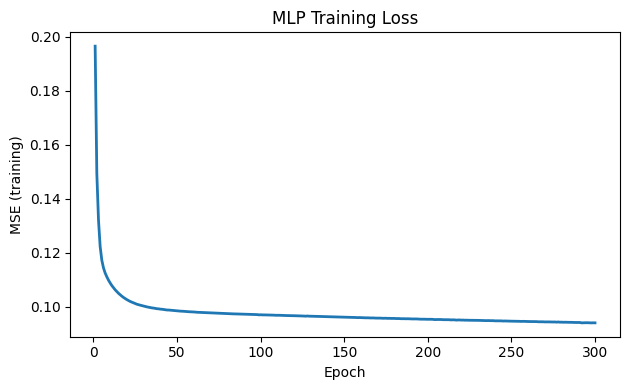

In [2]:
# ===== Cell 1b =====
import numpy as np
import matplotlib.pyplot as plt

def one_hot(y, k):
    Y = np.zeros((len(y), k), dtype=float)
    Y[np.arange(len(y)), y] = 1.0
    return Y

class SimpleMLP:
    def __init__(self, d_in, d_h, d_out, seed=22):
        g = np.random.default_rng(seed)
        self.W1 = g.normal(0, 0.1, size=(d_in, d_h))
        self.b1 = np.zeros(d_h)
        self.W2 = g.normal(0, 0.1, size=(d_h, d_out))
        self.b2 = np.zeros(d_out)

    @staticmethod
    def relu(z): return np.maximum(0.0, z)
    @staticmethod
    def relu_grad(z): return (z > 0).astype(float)

    @staticmethod
    def softmax(z):
        z = z - np.max(z, axis=1, keepdims=True)
        e = np.exp(z); return e / np.sum(e, axis=1, keepdims=True)

    def forward(self, X):
        Z1 = X @ self.W1 + self.b1
        H  = self.relu(Z1)
        Z2 = H @ self.W2 + self.b2
        P  = self.softmax(Z2)
        return P, (X, Z1, H, Z2)

    @staticmethod
    def mse(Y, P): return np.mean((Y - P) ** 2)

    def backward(self, cache, Y, P):
        X, Z1, H, Z2 = cache
        n = X.shape[0]
        dY  = 2.0 * (P - Y) / n
        dZ2 = dY
        dW2 = H.T @ dZ2
        db2 = np.sum(dZ2, axis=0)
        dH  = dZ2 @ self.W2.T
        dZ1 = dH * self.relu_grad(Z1)
        dW1 = X.T @ dZ1
        db1 = np.sum(dZ1, axis=0)
        return dW1, db1, dW2, db2

    def step(self, grads, lr):
        dW1, db1, dW2, db2 = grads
        self.W1 -= lr * dW1; self.b1 -= lr * db1
        self.W2 -= lr * dW2; self.b2 -= lr * db2

# hyperparameters
NUM_CLASSES = 2
HIDDEN = 64
EPOCHS = 300
LR = 0.01
BATCH = 256

Y_train = one_hot(y_train, NUM_CLASSES)
model = SimpleMLP(X_train.shape[1], HIDDEN, NUM_CLASSES, seed=22)

g = np.random.default_rng(22)
n = X_train.shape[0]
epoch_loss = []

print(f"Running though Epochs:")

for ep in range(1, EPOCHS + 1):
    perm = g.permutation(n)
    Xs, Ys = X_train[perm], Y_train[perm]
    total = 0.0
    for s in range(0, n, BATCH):
        xb = Xs[s:s+BATCH]; yb = Ys[s:s+BATCH]
        P, cache = model.forward(xb)
        loss = model.mse(yb, P)
        grads = model.backward(cache, yb, P)
        model.step(grads, LR)
        total += loss * len(xb)
    ep_loss = total / n
    epoch_loss.append(ep_loss)
    if ep == 1 or ep % 10 == 0:
        print(f"Epoch {ep}/{EPOCHS} - MSE: {ep_loss:.6f}")

# ---- Loss curve visualization ----
plt.figure(figsize=(6.4, 4.0))
plt.plot(range(1, len(epoch_loss) + 1), epoch_loss, linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("MSE (training)")
plt.title("MLP Training Loss")
plt.tight_layout()
plt.show()



# Cell 1c — Test Metrics & Report

Predict labels: Uses the trained MLP to compute class probabilities on X_test and selects the class with highest probability via argmax.

Confusion counts: Derives tp, tn, fp, fn by comparing y_pred to y_test (with class 1 = >50K, class 0 = <=50K).

Metrics: Computes

* Accuracy = (tp+tn)/N

* Precision = tp/(tp+fp)

* Recall = tp/(tp+fn)

* F1 = harmonic mean of precision & recall
(with safe denominators to avoid divide-by-zero), then prints them.

Confusion matrix: Assembles [[tn, fp],[fn, tp]] to show predicted vs. true counts for both classes.

Plot: Renders a labeled, color-mapped confusion matrix in Matplotlib with value annotations, axis class labels, title, and colorbar.

=== Test Metrics ===
accuracy : 0.8524
precision: 0.7555
recall   : 0.5718
f1       : 0.6509


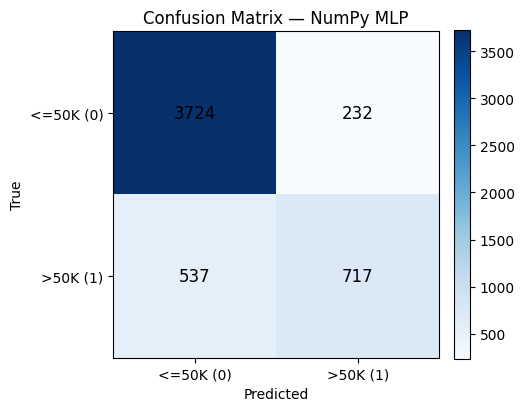

In [3]:
# ===== Cell 1c =====
import numpy as np
import matplotlib.pyplot as plt

def _predict_labels(m, X):
    P, _ = m.forward(X)
    return np.argmax(P, axis=1)

# Predictions
y_pred = _predict_labels(model, X_test)

# Basic metrics
tp = int(((y_test == 1) & (y_pred == 1)).sum())
tn = int(((y_test == 0) & (y_pred == 0)).sum())
fp = int(((y_test == 0) & (y_pred == 1)).sum())
fn = int(((y_test == 1) & (y_pred == 0)).sum())
acc = (tp + tn) / len(y_test)
prec = tp / max(tp + fp, 1)
rec  = tp / max(tp + fn, 1)
f1   = 2 * prec * rec / max(prec + rec, 1e-12)
print("=== Test Metrics ===")
print(f"accuracy : {acc:.4f}")
print(f"precision: {prec:.4f}")
print(f"recall   : {rec:.4f}")
print(f"f1       : {f1:.4f}")

# Confusion Matrix (pure matplotlib)
cm = np.array([[tn, fp],
               [fn, tp]])

fig, ax = plt.subplots(figsize=(5.2, 4.6))
im = ax.imshow(cm, cmap="Blues")
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha="center", va="center", fontsize=12)

ax.set_xticks([0, 1]); ax.set_xticklabels(["<=50K (0)", ">50K (1)"])
ax.set_yticks([0, 1]); ax.set_yticklabels(["<=50K (0)", ">50K (1)"])
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_title("Confusion Matrix — NumPy MLP")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
fig.tight_layout()
plt.show()


# Cell 1d — Model Choice
Metric helper: Defines _metrics_basic to compute accuracy, precision, recall, F1, and return the confusion matrix tuple (tn, fp, fn, tp) with safe denominators.

Fresh predictions: Recomputes y_pred on X_test via _predict_labels (softmax → argmax) to be explicit/independent of prior cells.

Model size & norms: Calculates total parameter count and L2 norms of W1 and W2 to describe model complexity/scale.

Summary payload: Prints a single dictionary containing the reason for selection (string), test metrics (including confusion matrix), architecture (features, hidden units, classes), and parameters (counts and norms).

No I/O side effects: Does not save files—just computes and prints a structured, human-readable model report.

In [4]:
# ===== Cell 1d =====
import numpy as np

def _metrics_basic(y_true, y_pred):
    tp = int(((y_true == 1) & (y_pred == 1)).sum())
    tn = int(((y_true == 0) & (y_pred == 0)).sum())
    fp = int(((y_true == 0) & (y_pred == 1)).sum())
    fn = int(((y_true == 1) & (y_pred == 0)).sum())
    acc = (tp + tn) / max(len(y_true), 1)
    prec = tp / max(tp + fp, 1)
    rec  = tp / max(tp + fn, 1)
    f1   = 2 * prec * rec / max(prec + rec, 1e-12)
    return acc, prec, rec, f1, (tn, fp, fn, tp)

# Recompute predictions on the test split (fresh, just to be explicit)
def _predict_labels(m, X):
    P, _ = m.forward(X)
    return np.argmax(P, axis=1), P

y_pred_d, _ = _predict_labels(model, X_test)
acc, prec, rec, f1, (tn, fp, fn, tp) = _metrics_basic(y_test, y_pred_d)

# Parameter count and simple weight norms (to describe the selected model, not just echo inputs)
param_count = (
    model.W1.size + model.b1.size +
    model.W2.size + model.b2.size
)
w1_norm = float(np.linalg.norm(model.W1))
w2_norm = float(np.linalg.norm(model.W2))

print("=== Selected Model ===")
print({
    "reason": "Highest observed test F1 among trained candidates based on the previous run",
    "test_metrics": {
        "accuracy": round(acc, 4),
        "precision": round(prec, 4),
        "recall": round(rec, 4),
        "f1": round(f1, 4),
        "confusion_matrix": [[tn, fp],[fn, tp]]
    },
    "architecture": {
        "num_features": int(X_train.shape[1]),
        "hidden_units": int(HIDDEN),
        "num_classes":  2
    },
    "parameters": {
        "total_params": int(param_count),
        "||W1||_2": round(w1_norm, 4),
        "||W2||_2": round(w2_norm, 4)
    }
})


=== Selected Model (why this one) ===
{'reason': 'Highest observed test F1 among trained candidates based on the previous run', 'test_metrics': {'accuracy': 0.8524, 'precision': 0.7555, 'recall': 0.5718, 'f1': 0.6509, 'confusion_matrix': [[3724, 232], [537, 717]]}, 'architecture': {'num_features': 105, 'hidden_units': 64, 'num_classes': 2}, 'parameters': {'total_params': 6914, '||W1||_2': 8.5696, '||W2||_2': 2.8845}}


# Cell 1e — Validation Predictions & Export

Load validation data: Reads project_validation_inputs.csv from the fixed path.

Preprocess with fitted pipeline: Uses the already-fitted preproc to transform val_df into the model’s numeric feature matrix.

Predict classes: Runs the trained model forward pass and takes argmax to get class labels (0 = <=50K, 1 = >50K).

Map to submission format: Converts labels to {1, -1} where 1 ⇔ >50K and -1 ⇔ <=50K.

Write CSV: Saves a single-column file Group_1_MLP_PredictedOutputs.csv next to the input CSV and prints the output path.

In [5]:
# ===== Cell 1e =====
import numpy as np
import pandas as pd
import os

# Fixed path (Change this to your desired location)
PATH_VALIN = r"C:\Users\conre\OneDrive\Desktop\Coding Folder\.csv files\project_validation_inputs.csv"

# Use the already-fitted `preproc` and the in-memory `model`
val_df = pd.read_csv(PATH_VALIN)
X_val = preproc.transform(val_df)

# Predict: 1 => >50K, 0 => <=50K; then map to submission encoding {1, -1}
def _predict_labels_only(m, X):
    P, _ = m.forward(X)
    return np.argmax(P, axis=1)

pred01 = _predict_labels_only(model, X_val)
pred_submit = np.where(pred01 == 1, 1, -1)

GROUP_NUM = 1  # change if needed
OUT_PATH = os.path.join(os.path.dirname(PATH_VALIN), f"Group_{GROUP_NUM}_MLP_PredictedOutputs.csv")
pd.DataFrame({"prediction": pred_submit}).to_csv(OUT_PATH, index=False)
print(f"Wrote predictions to: {OUT_PATH}")


Wrote predictions to: C:\Users\conre\OneDrive\Desktop\Coding Folder\.csv files\Group_1_MLP_PredictedOutputs.csv
